In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functions import basic
from functions import interaction
from functions import evolution
%matplotlib inline

In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# reading input file
filename = "fcc100a256.txt"
lattice = basic.read_file(filename)

In [4]:
# computing ditances, finding neighbours

# no PBC test
start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice)
print(f'no PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice, PBC=True)
print(f'PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

no PBC - 100 iterations; computing time: 0.52 seconds
PBC - 100 iterations; computing time: 0.61 seconds


In [15]:
# calculating potential energy
mask,distances = basic.find_neighbours(*lattice)

# approximate LJ
start = time.process_time()
for i in range(100):
    LJA = interaction.lennard_jones_approx(distances)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# true LJ
start = time.process_time()
for i in range(100):
    LJ = interaction.lennard_jones(distances)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ: {LJA:.2f}')
print(f'true LJ: {LJ:.2f}')

approximate LJ - 100 iterations; computing time: 0.72 seconds
true LJ - 100 iterations; computing time: 0.83 seconds

approximate LJ: -453.45
true LJ: -532.48


In [16]:
# calculating forces

# approximate LJ
start = time.process_time()
for i in range(100):
    FxA,FyA,FzA = interaction.calc_force_approx(*lattice,distances,PBC=True)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# approximate LJ
start = time.process_time()
for i in range(100):
    Fx,Fy,Fz = interaction.calc_force(*lattice,distances,PBC=True)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ, force on 0-th atom: {FxA[1]:.2f},{FyA[1]:.2f},{FzA[1]:.2f}')
print(f'true LJ, force on 0-th atom: {Fx[1]:.2f},{Fy[1]:.2f},{Fz[1]:.2f}')

approximate LJ - 100 iterations; computing time: 2.48 seconds
true LJ - 100 iterations; computing time: 3.04 seconds

approximate LJ, force on 0-th atom: 0.00,0.00,-0.11
true LJ, force on 0-th atom: 0.00,0.00,0.37


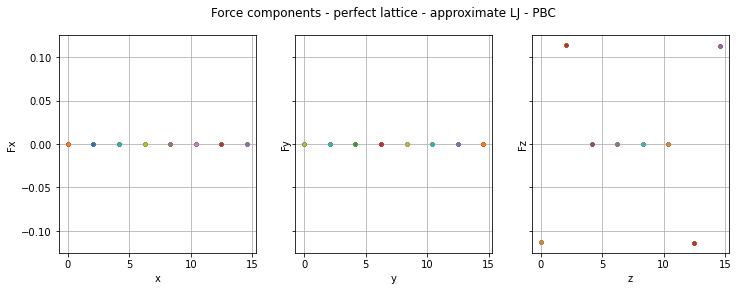

In [7]:
n_atoms,sx,sy,sz,x,y,z = lattice

fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

for i in range(255):
    axs[0].plot(x[i],FxA[i],'.')
    axs[1].plot(y[i],FyA[i],'.')
    axs[2].plot(z[i],FzA[i],'.')

for i in range(3):
    axs[i].grid()

axs[0].set_xlabel('x')
axs[0].set_ylabel('Fx')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Fy')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Fz')

fig.suptitle('Force components - perfect lattice - approximate LJ - PBC')
plt.show()

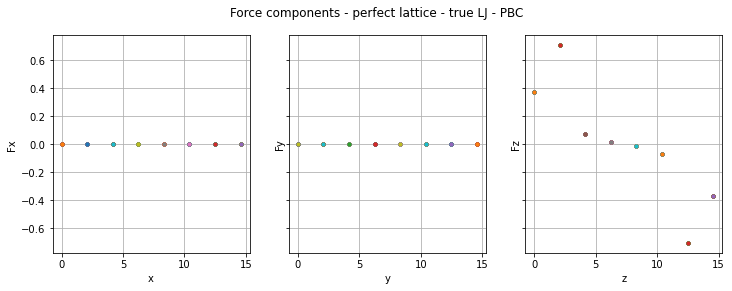

In [8]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

for i in range(255):
    axs[0].plot(x[i],Fx[i],'.')
    axs[1].plot(y[i],Fy[i],'.')
    axs[2].plot(z[i],Fz[i],'.')

for i in range(3):
    axs[i].grid()

axs[0].set_xlabel('x')
axs[0].set_ylabel('Fx')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Fy')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Fz')

fig.suptitle('Force components - perfect lattice - true LJ - PBC')
plt.show()

In [9]:
# initializing speed
m_ag = 108*1.66e-27/16
kb = 1/11603
T = 100

start = time.process_time()
vx,vy,vz = basic.initialize_speed(n_atoms,x,y,z,T,remove_translation=True,remove_rotation=True)
print(f'speed initialization; computing time: {time.process_time() - start :.3f} seconds\n')

v2 = vx**2 + vy**2  + vz**2
Ekin = 0.5*m_ag*np.sum(v2)
Tkin = 2*Ekin/(3*n_atoms*kb)  

Ix = np.sum(vy*z-vz*y)
Iy = np.sum(vz*x-vx*z)
Iz = np.sum(vx*y-vy*x)

print('translation removal check:')
print(f'    mean vx: {np.mean(vx)}')
print(f'    mean vy: {np.mean(vy)}')
print(f'    mean vz: {np.mean(vz)}\n')
print('rotation removal check:')
print(f'    Ix: {Ix}')
print(f'    Iy: {Iy}')
print(f'    Iz: {Iz}\n')
print(f'Set temperature: {T:.2f}K; real temperature: {Tkin:.2f}K')

speed initialization; computing time: 0.007 seconds

translation removal check:
    mean vx: -0.000171661376953125
    mean vy: -0.00011444091796875
    mean vz: -0.0001506805419921875

rotation removal check:
    Ix: 14529786935131.719
    Iy: 412743152209708.56
    Iz: 127838761763375.38

Set temperature: 100.00K; real temperature: 135.16K


### Test zone - used for quick tests and monkey patch

In [89]:
def initialize_speed(n_atoms,x,y,z,T,remove_translation=True,remove_rotation=True):
    c = np.sqrt(3*kb*T/m_ag)
    vx = c*(2*np.random.rand(n_atoms))
    vy = c*(2*np.random.rand(n_atoms))
    vz = c*(2*np.random.rand(n_atoms))
    if remove_translation:
        vx = np.asarray([v - np.mean(vx) for v in vx])
        vy = np.asarray([v - np.mean(vy) for v in vy])
        vz = np.asarray([v - np.mean(vz) for v in vz])
    v2 = vx**2 + vy**2  + vz**2
    Ekin = 0.5*m_ag*np.sum(v2)
    Tkin = 2*Ekin/(3*n_atoms*kb)     
    vx = vx*np.sqrt(T/Tkin)
    vy = vy*np.sqrt(T/Tkin)
    vz = vz*np.sqrt(T/Tkin)
    if remove_rotation:
        Ix = np.sum(vy*z-vz*y)
        Iy = np.sum(vz*x-vx*z)
        Iz = np.sum(vx*y-vy*x)
        mask_x = (x==max(x))
        mask_y = (y==max(x))
        mask_z = (z==max(x))
        mask_Ix = mask_y*mask_z
        mask_Iy = mask_z*mask_x
        mask_Iz = mask_x*mask_y
        nx = np.sum(mask_Ix)
        ny = np.sum(mask_Iy)
        nz = np.sum(mask_Iz)
        Ix_atom = Ix/(nx*max(x))
        Iy_atom = Iy/(ny*max(y))
        Iz_atom = Iz/(nz*max(z))
        vx_add = np.random.rand()*max(vx)
        vy_add = vx_add - Ix_atom - Iy_atom - 2*Iz_atom
        vz_add = vx_add + Iy_atom + Iz_atom
        vx = vx + vx_add*mask_Iz - vx_add*mask_Iy
        vy = vy + vy_add*mask_Ix - vy_add*mask_Iz
        vz = vz + vz_add*mask_Iy - vz_add*mask_Ix
    return vx,vy,vz

In [90]:
vx,vy,vz = initialize_speed(n_atoms,x,y,z,T,remove_translation=True,remove_rotation=True)

v2 = vx**2 + vy**2  + vz**2
Ekin = 0.5*m_ag*np.sum(v2)
Tkin = 2*Ekin/(3*n_atoms*kb)  

Ix = np.sum(vy*z-vz*y)
Iy = np.sum(vz*x-vx*z)
Iz = np.sum(vx*y-vy*x)

print('translation removal check:')
print(f'    mean vx: {np.mean(vx)}')
print(f'    mean vy: {np.mean(vy)}')
print(f'    mean vz: {np.mean(vz)}\n')
print('rotation removal check:')
print(f'    Ix: {Ix}')
print(f'    Iy: {Iy}')
print(f'    Iz: {Iz}\n')
print(f'Set temperature: {T:.2f}K; real temperature: {Tkin:.2f}K')

translation removal check:
    mean vx: -4.9591064453125e-05
    mean vy: 1.9073486328125e-05
    mean vz: -8.487701416015625e-05

rotation removal check:
    Ix: 28029001974924.0
    Iy: 237623416638566.66
    Iz: -111086964833950.75

Set temperature: 100.00K; real temperature: 177.84K


In [86]:
72872313063639/1251121339013/4

14.561400000004678

In [10]:
n_atoms,sx,sy,sz,x,y,z = lattice

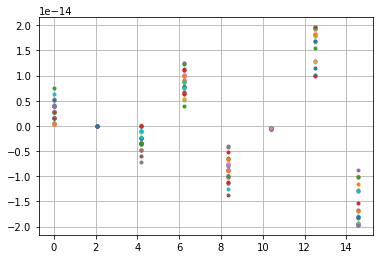

In [11]:
for i in range(255):
    plt.plot(x[i],Fx[i],'.')
plt.grid()

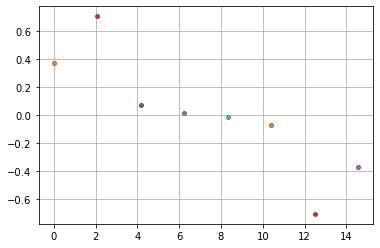

In [12]:
for i in range(255):
    plt.plot(z[i],Fz[i],'.')
plt.grid()

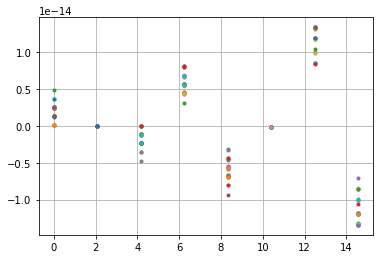

In [13]:
for i in range(255):
    plt.plot(x[i],FxA[i],'.')
plt.grid()

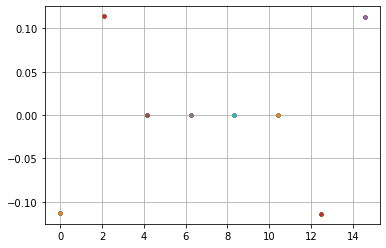

In [14]:
for i in range(255):
    plt.plot(z[i],FzA[i],'.')
plt.grid()